This notebook ilustrates a wavelet-based methodology centered around the **Wavelet Area Interpretation (WAI)** to conduct data analysis. 

20 years of Gross Primary Productivity collected above the Hesse temperate  forest (North-Eastern France) are used as a case-example. This choice stems from the signal’s shape, characterized by well-marked diurnal and annual trends, and the availability of decade-long datasets through international networks such as ICOS or FLUXNET. These characteristics tend to complicate classical WT analyses, providing an effective illustration of the benefits of this approach. Nonetheless, it can readily be applied to other ecological (or broader) signals.

For detailed explanations and possible applications, please refer to the related publication.

In [2]:
"""
Created on Fri Feb 14 2025

@author: Jonathan Bitton
"""
# Standard library imports
import os
import sys
from datetime import datetime,timedelta
import warnings

# Customize the warning format (exclude file paths and function names)
def custom_warning_format(message, category, filename, lineno, line=None):
    return f"{category.__name__}: {message}"
# Apply the custom warning format
warnings.formatwarning = custom_warning_format

# Get the directory of the current script
current_dir = os.path.dirname(os.path.abspath('aExample_Script.ipynb'))

# Add the src folder to the Python path
sys.path.append(os.path.join(current_dir, "..", "src"))

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Local application/library specific imports
from cwtransform import Wavelet_Transform as WT

# Read the data from the comma-delimited file
data = pd.read_csv(os.path.join(current_dir, "..", "data", "GPPdata.txt"), 
                   parse_dates=['Time'], index_col='Time')

# Convert the 'Time' column to datetime
data.index = pd.to_datetime(data.index, format='%d-%b-%Y %H:%M:%S', errors='coerce')
# Sampling interval
ts = timedelta(minutes=30)
# Time data
xdata = data.index

To conduct a (continuous) wavelet analysis, resulting coefficients' amplitude is generally represented for each couple position-frequency (or position-period) in a 3-dimensional graph, called **scalogram**. 

In this case-study, we will use the Morlet wavelet due to its suitability for graphical representations.

Using DataFrame index as x-axis for the scalogram

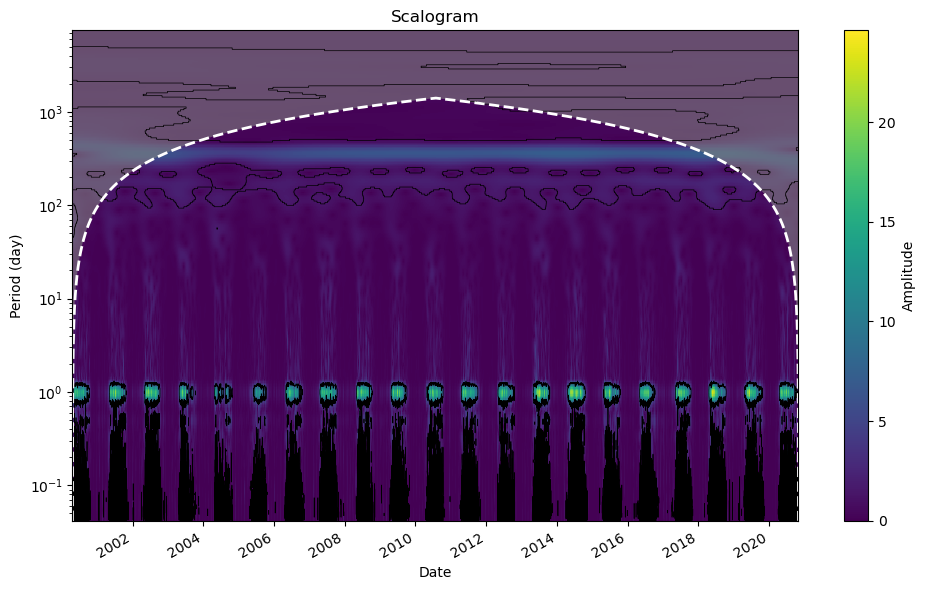

In [5]:
# Step 1a: Scalogram (Morlet wavelet)
WT(data, ts=ts, figure=True, signif=True, plotunits='days')

The **scalogram** features prominent yearly and daily components throughout the 20 years of available data.
However, intermidiate regions (1 day to 1 year) display significant coefficients that may be meaningfull.

To visualize wavelet coefficient distribution in these regions, mean period bands can be computed.

In [2]:
#%% Step 1b: Compute mean periodic bands
# First, define wavelet and apply cwt
wname = "dog2"
wdata = WT(data, wname=wname, ts=ts)

# Period bands to study: 1 year and 1:6 months
pstr = ["y1"] + ["m" + str(i) for i in range(6, 0, -1)]
''' Optional parameters to pass to argument compute_mean_coeff (if not default)
pval = np.concatenate(([365], np.arange(180, 0, -30))) # conversion to days (default in function)
pspread = np.concatenate(([30], np.tile(15,6))) # spread in days for mean computation (default in function)
Units = 'days' # units of pval and pspread if ts is timedelta (days, default in function)
pdate = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(0, 365)]
'''

# Compute mean coefficients for the specified period bands
wdata.compute_mean_coef(pstr)

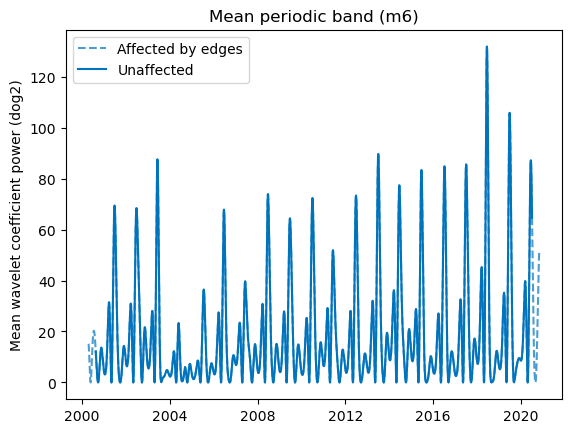

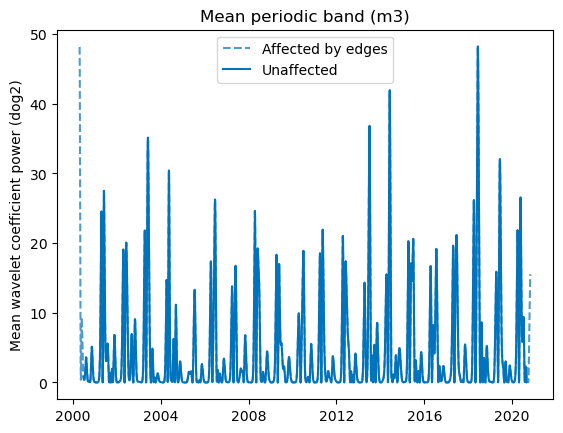

In [3]:
#%% Step 1c: Plot mean period bands for the given period
per = ["m6", "m3"] # Period chosen (among pstr)

for p in per:
    plt.figure()

    # Edge-affected coefficients (dashed line)
    plt.plot(xdata, wdata.mean_coef['power'][p], linestyle='--', 
             label='Affected by edges', color=[0.00, 0.45, 0.74], alpha=0.7)
    # Unaffected coefficients (solid line)
    plt.plot(xdata, wdata.mean_coef['powercoi'][p], linestyle='-', 
             label='Unaffected', color=[0.00, 0.45, 0.74])

    # Titles and labels
    plt.title(f"Mean periodic band ({p})")
    plt.ylabel(f"Mean wavelet coefficient power ({wname})")
    plt.legend()

    # Display the plot
    plt.show()

Three yearly repeating peaks in **April**, **June** and **November** found inside the 6-month period band. 

By reducing the period, these repeating peaks are still recognizable, although additionnal peaks appear.

To group related peaks, we will first select a high period were they are visible (e.g. 6 months) then identify their lower period counterpart (until for e.g. 2 months) using a sufficient number of intermidiate peaks (e.g. 1 per month) to track their location precisely from high to low periods.

In [4]:
#%% Step 1d: Select peaks in periodic bands
# Periods to study 
pstr = ["m" + str(i) for i in range(6, 1, -1)] # 6 months to 2 months, 1 peak per month for tracking

# Filter values for peak location
mts = {'apr':np.array((3,4)), # First peak in March/April
       'jun':np.array((5,6,7)), # Second peak in June/July/August
       'nov':np.array((10,11))} # Third peak in October/November
filter_per = 'month' # Units for filter values (months)

''' Optional parameters to pass to argument compute_peaks (if not default)
per = 'year' # peaks recurring on a yearly period
thresh = -np.inf # threshold for peak detection (value of peak > threshold)
coi = True # Delete edge-affected peaks 
'''

# Compute peaks for the specified period bands
wdata.compute_peaks(xdata, pstr, filter_val=mts, filter_per=filter_per)

Peaks closest to previous (higher) period (e.g. 'm3' for 'm2') retained for:
m2: 2016, 2017
Peaks closest to previous (higher) period (e.g. 'm3' for 'm2') retained for:
m5: 2004
m4: 2004
m3: 2001, 2004, 2005, 2009, 2014, 2015, 2016, 2020
m2: 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020
Due to missing previous period peaks, highest peak value retained for:
m2: 2000
Peaks closest to previous (higher) period (e.g. 'm3' for 'm2') retained for:
m4: 2001
m3: 2001, 2005, 2012, 2019
m2: 2000, 2001, 2003, 2004, 2005, 2006, 2010, 2018, 2019


Peaks in period bands correspond to maxima in wavelet cofficients at a certain period.

To interpret these peaks, we suggest graphically representing the computation steps of associated wavelet coeffcients. Considering a time-varying signal $x(t)$ and a wavelet $\psi(t)$, the CWT is expressed as:

$$W(a,b) = \int_{-\infty}^{+\infty} x(t) \bar{\psi}_{a,b} (t) dt$$

According to the CWT formula, a wavelet coefficient $W(a,b)$ may be constructed by following three steps (omitting the complex conjugate $\ \bar{}\ $ and the normalization factor, since qualitative results are sought):
- Computing the chosen wavelet at scale 𝑎 and position 𝑏, i.e. $\psi_{a,b} (t) = \psi\left(\frac{t-b}{a}\right)$

- Defining a product curve by multiplying 𝑥(𝑡) with (the complex conjugate of) the wavelet.

- Computing the area under the product curve by positively accounting for contributions that lie above the t=0 axis and negatively for those below.

This approach, named **Wavelet Area Interpretation (WAI)**, enable the interpretation of a wavelet coefficient based on the areas contributing to its calculation.

Using DataFrame index as xdata


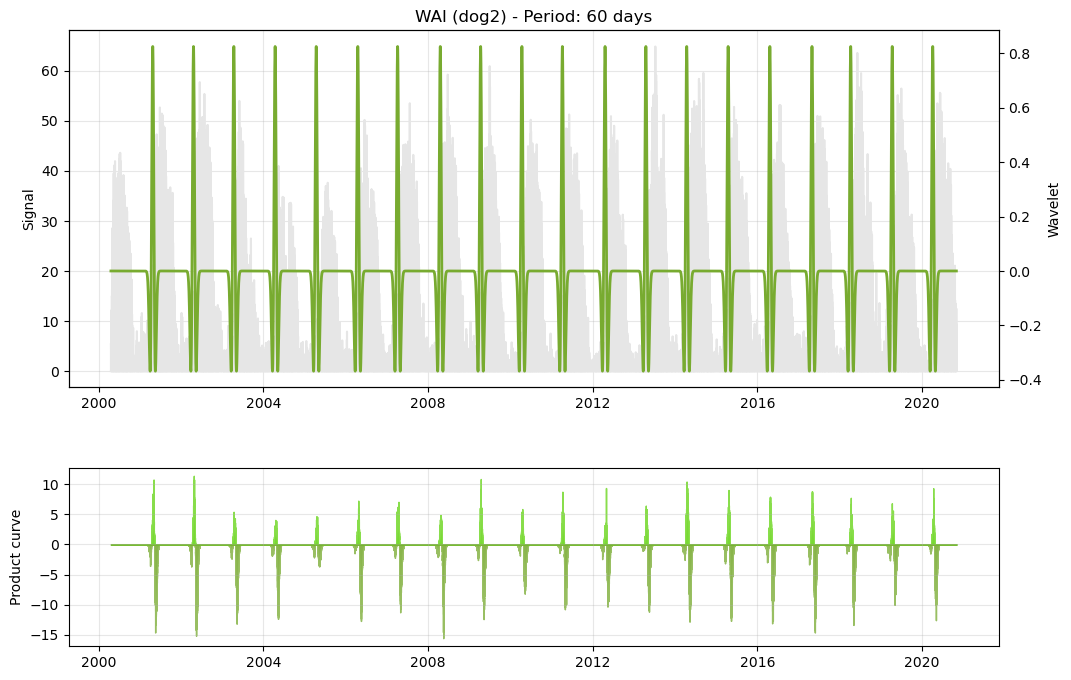

In [5]:
#%% Step 2: Vizualize wavelet coefficients
idx = np.arange(2000,2020+1,1) # Index of the data to visualize (e.g. 2000 to 2020)
# idx = [2005, 2008] # For example, to visualize only 2005 and 2008
# idx = wdata.peaks['apr']['m2loc'] # For example, to visualize only the peaks in the m2 period for 'apr' repeating peaks
# idx = datetime(2005, 4, 1, 19, 45, 0) # For example, to visualize only the data for April 2005 at 19:45

per = 'm2' # Period to visualize (e.g. 2 months)
# per = timedelta(days=60) # For example, to visualize a period of 60 days (same type as ts)
perpeak = 'apr' # Peak to visualize (e.g. apr, jun, nov)

filter_dates = None # Dates to filter (e.g. None for no filtering)
filter_per = 'month' # Filter period (e.g. 'month' for monthly data)

pmode = 'together' # Plotting mode ('together' for all data together, 'separate' for separate plots)
tit = 'default' # Title of the plot ('default' for displaying period and time, or a custom title)

# Add zoom 
# zoom = [datetime(2007, 1, 1), datetime(2009, 12, 31)] # For example, to zoom in on April 2005
# zoom = None # For no zoom

# Plot the wavelet coefficients for the specified period and peak
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit)


Zoom on 2008 (for example):

Using DataFrame index as xdata


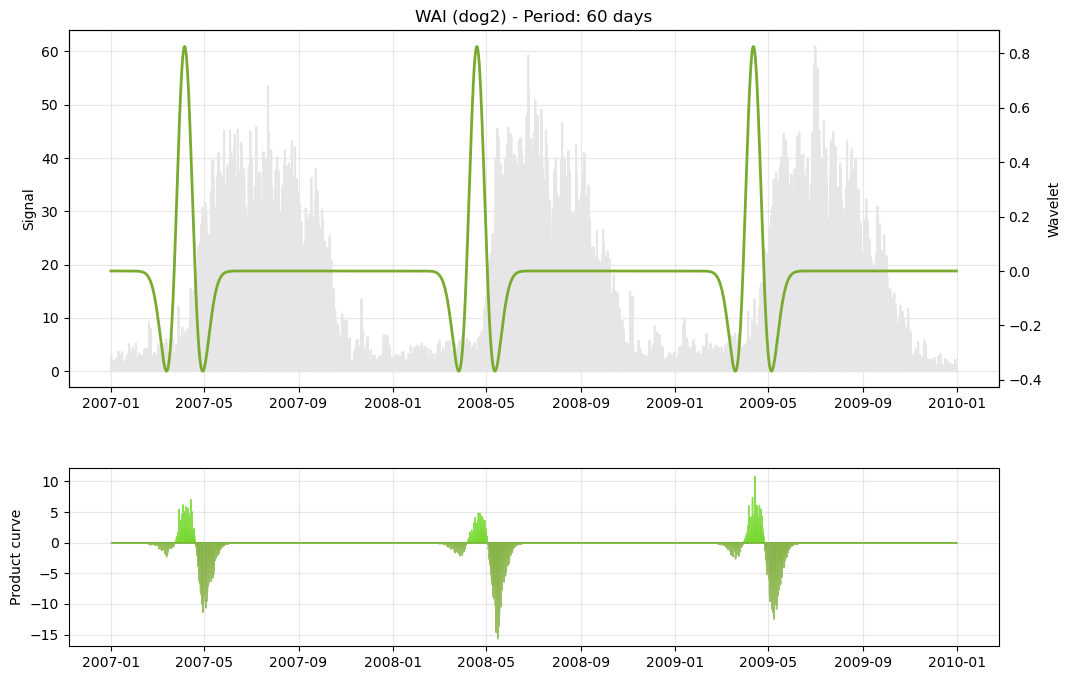

In [6]:
# Zoom on specific dates
xlims = [datetime(2007, 1, 1), datetime(2009, 12, 31)]

# WAI with zoom
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit, xlims=xlims)


Exploiting the WAI, one may associate repeated peaks with different interpretations based on contributing areas:

|              | April                                       | June                                                   | November                                    |
|:----------------:|:-------------------------------------------:|:------------------------------------------------------:|:-------------------------------------------:|
| **Wavelet lobe** | Right                                       | Center                                                 | Left                                        |
| **6-month peak** | Signal values during the first half of the growing season  | Signal peak values and smoothness at the middle of the growing season | Signal values during the second half of the growing season |
| **2-month peak** | Rate of the signal rise at the onset of the growing season | Importance of fluctuations in the signal peak             | Rate of signal decrease at the end of the growing season   |

Based on these interpretations, several **indicators** of signal intra-annual dynnamics are computed.

The first indicator represents the **steepness of signal rise**. It is computed using the following considerations:
- April peak, to capture rising signal values.
- Normalizing signal between 0 and 1, so that signal values indicate relative growth.
- dog1 wavelet, to capture rising values with the right lobe and apply a penality with the left lobe.
- Sufficently low period (3 months, considering that the right lobe should cover the increasing signal time, which is approximately 1.5 months).


Peaks closest to previous (higher) period (e.g. 'm3' for 'm2') retained for:
m4: 2007
m3: 2004, 2007, 2009, 2013, 2014, 2016, 2020
m2: 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020


Using DataFrame index as xdata


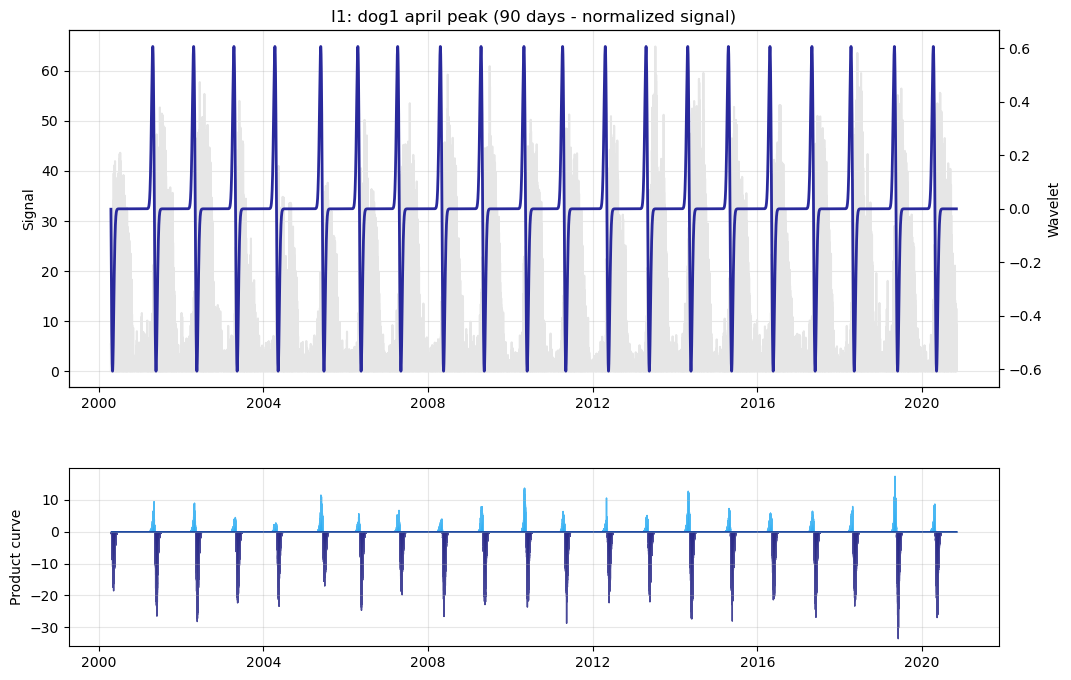

In [7]:
#%% Step 3a: First Indicator : Steepness of signal rise
# Normalizing signal by yearly maximum values
# Smoothing data (moving mean)
smooth_data = data.rolling(window=40*48, min_periods=1, center=True).mean()  # 40 days, 48 samples/day
# Resample to yearly frequency and compute the maximum for each year
max_smooth_data = smooth_data.resample('Y').max().iloc[:,0]
max_smooth_data.index = max_smooth_data.index.year
# Divide each data point by its corresponding yearly maximum
norm_data = data['GPP']/data.index.year.map(max_smooth_data)

# Wavelet and periods
wname = 'dog1'; # Wavelet to use
pstr = ["m" + str(i) for i in range(7, 1, -1)] # Periods: start at m7 (used for I2) to track peaks until m3 (used for I1)

# Create Wavelet Transform object and perform cwt
wdata_norm = WT(norm_data, wname=wname, ts=ts)

# Compute mean wavelet coefficients for period bands in pstr
wdata_norm.compute_mean_coef(pstr)

# Define April peaks
mts = {'apr':np.array((4,5,6))}  # Months (later than DOG2)
filter_per = 'month'

wdata_norm.compute_peaks(xdata, pstr, filter_val=mts, filter_per=filter_per)

# Indicator
I1 = wdata_norm.peak[wname][next(iter(mts))]['m3value'] # 3 months
I1.iloc[4] = np.nan # Sensor malfunctionning in June 2004 => Delete 2004

# Plotting - WAI for I1
pmode = 'together' # Plotting mode
wdata_norm.WAI(wdata_norm.peak[wname][next(iter(mts))]['m3loc'], "m3", 
               data, plotting_mode=pmode, 
               title='I1: dog1 april peak (90 days - normalized signal)')


Zoom:

Using DataFrame index as xdata


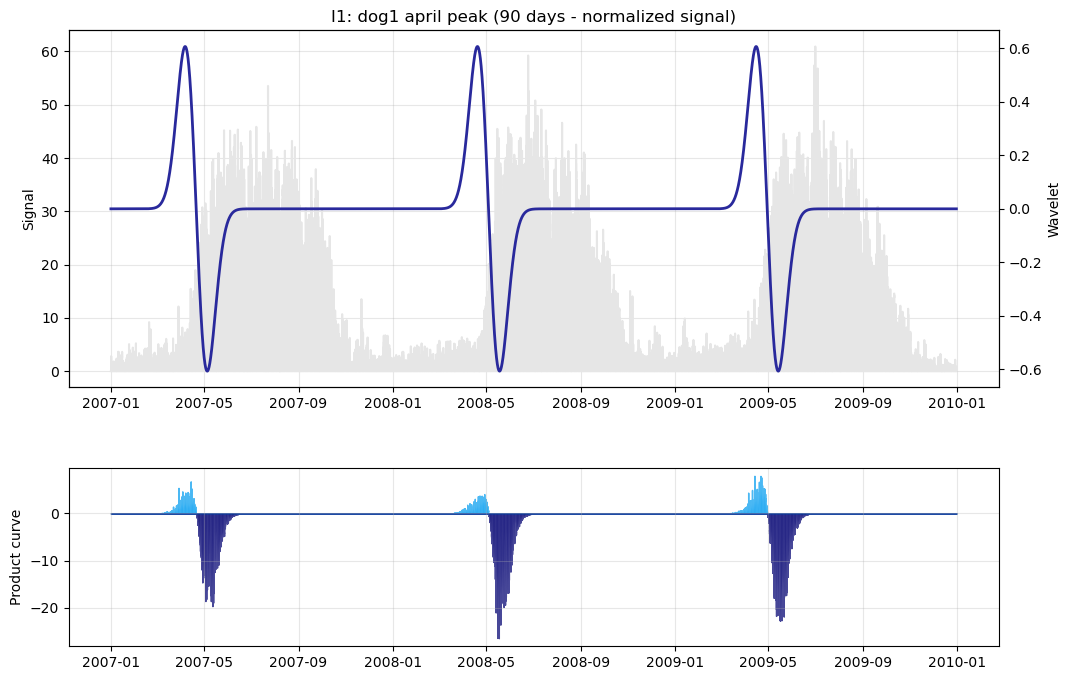

In [8]:
# Zoom on specific dates
xlims = [datetime(2007, 1, 1), datetime(2009, 12, 31)]

# WAI with zoom
wdata_norm.WAI(wdata_norm.peak[wname][next(iter(mts))]['m3loc'], "m3", 
               data, plotting_mode=pmode, 
               title='I1: dog1 april peak (90 days - normalized signal)',
               xlims=xlims)

The second indicator represents the **signal peaking values**. It is computed using the following considerations:
- Gaussian function, to best capture GPP peak in June.
- Period of 7 months, such that the support of the function represents approximately 4 months (theoretical length of the peak).
- Dates taken as minimum (right lobe) of dog1 april peak. This wavelet localizes the peak more precisely due to its suitability for edge detection.

For period selected (m7), support = 122 days (used for I2)
Using DataFrame index as xdata


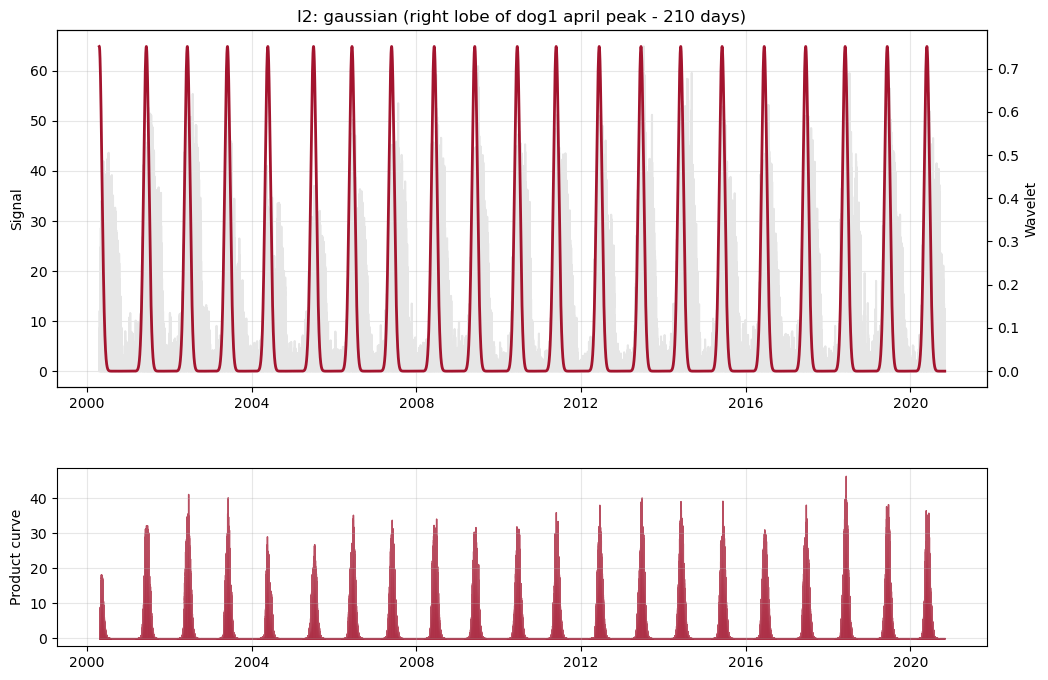

In [9]:
#%% Second Indicator : signal peaking values
# Wavelet selection
wdata.set_wavelet('gauss')

# Compute wavelet transform with the new wavelet
wdata.cwt(data)

# Selecting period
per = "m7" # Period to consider, based on support = ~2*(base to peak GPP time) = 2*60days
pervalue = timedelta(days=int(per[1:])*30) # Convert to days
print(f'For period selected ({per}), support = {wdata.support_period(pervalue):.0f} days (used for I2)')

# June values as defined by Gaussian positionned on dates of min(DOG1) for each period
wname = 'dog1'
min_dog1_loc = wdata_norm.translate_peak(wdata_norm.peak[wname]['apr'], per, wname) # Find minimum of wavelet

# Gaussian Analyzing function
wname = 'gauss'
# Compute mean wavelet coefficients
wdata.compute_mean_coef(per)

# Indicator: June values by positionning Gaussian on DOG1 times (follows ideal peak + values)
I2 = wdata.mean_coef['powercoi'].loc[xdata.isin(min_dog1_loc[f"{per}loc"]), per]
I2 = pd.concat([pd.Series([np.nan]), I2], ignore_index=True)# Add NaN for 2000 (prepend NaN)
I2.iloc[4] = np.nan # Set 2004 to NaN

# Plotting - WAI for I2
wdata.WAI(min_dog1_loc[f"{per}loc"], "m7", data,
          plotting_mode=pmode, 
          title='I2: gaussian (right lobe of dog1 april peak - 210 days)')


Zoom:

Using DataFrame index as xdata


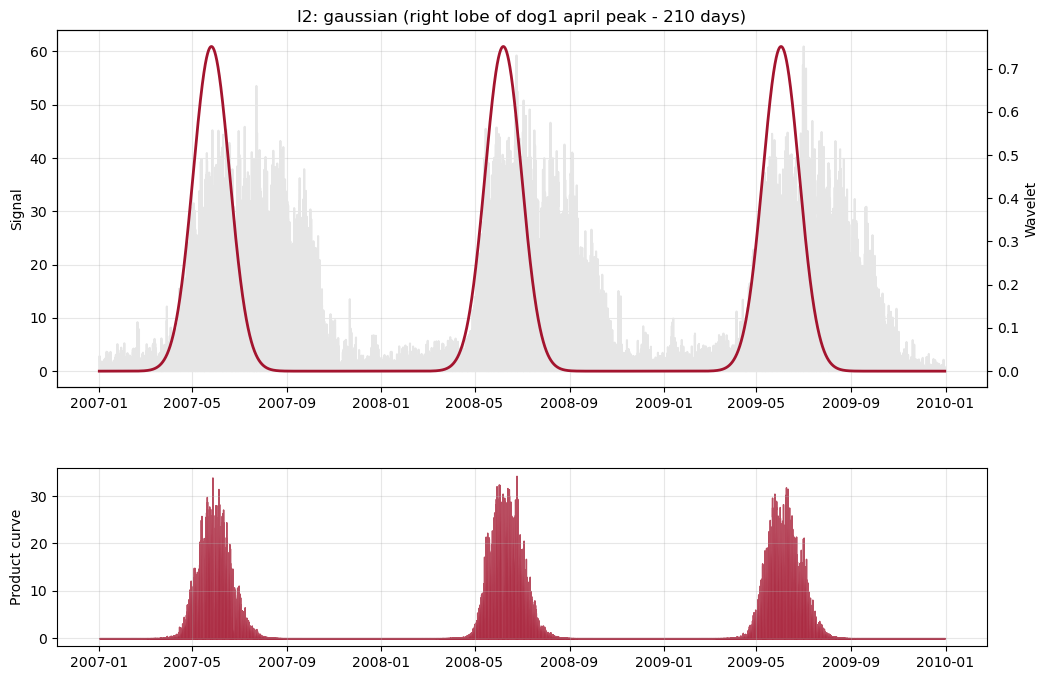

In [10]:
# Zoom on specific dates
xlims = [datetime(2007, 1, 1), datetime(2009, 12, 31)]

# WAI with zoom
wdata.WAI(min_dog1_loc[f"{per}loc"], "m7", data,
          plotting_mode=pmode, 
          title='I2: gaussian (right lobe of dog1 april peak - 210 days)',
          xlims=xlims)

The third indicator represents the **mid-season drop in signal values**. It is computed using the following considerations:
- Dog2 June peak used as a proxy for the drop, as it subtracts the second half of signal values from the first.
- Its value is divided by the November dog2 peak to (1) work in relative values and (2) obtain a complete wavelet out of the growing season, making its influence negligible.

Using DataFrame index as xdata


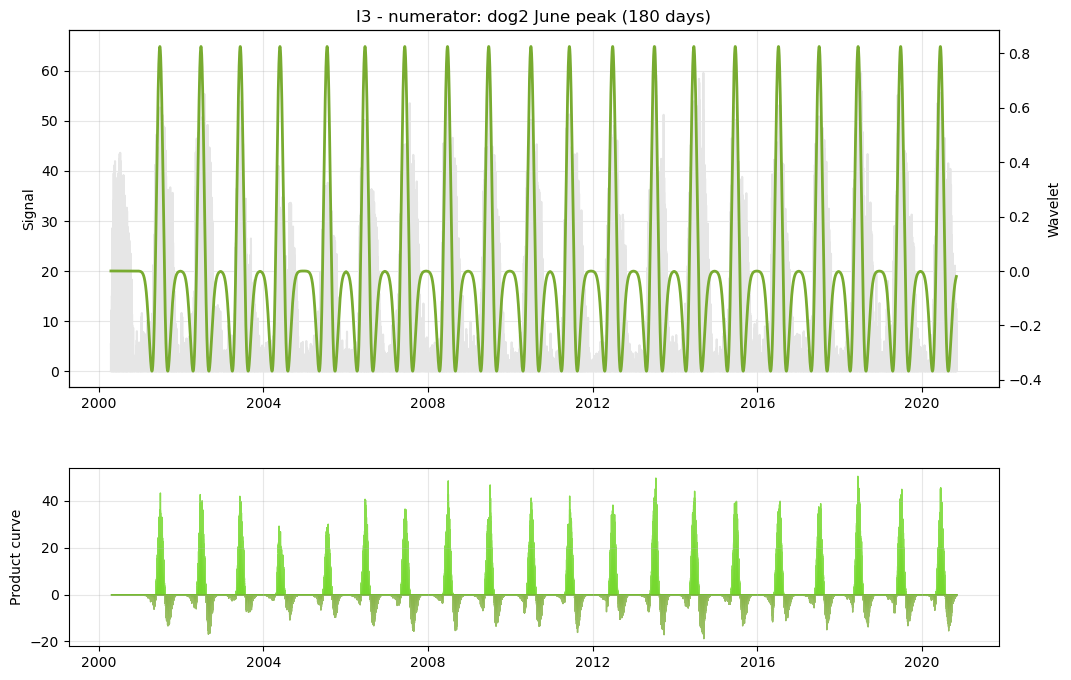

Using DataFrame index as xdata


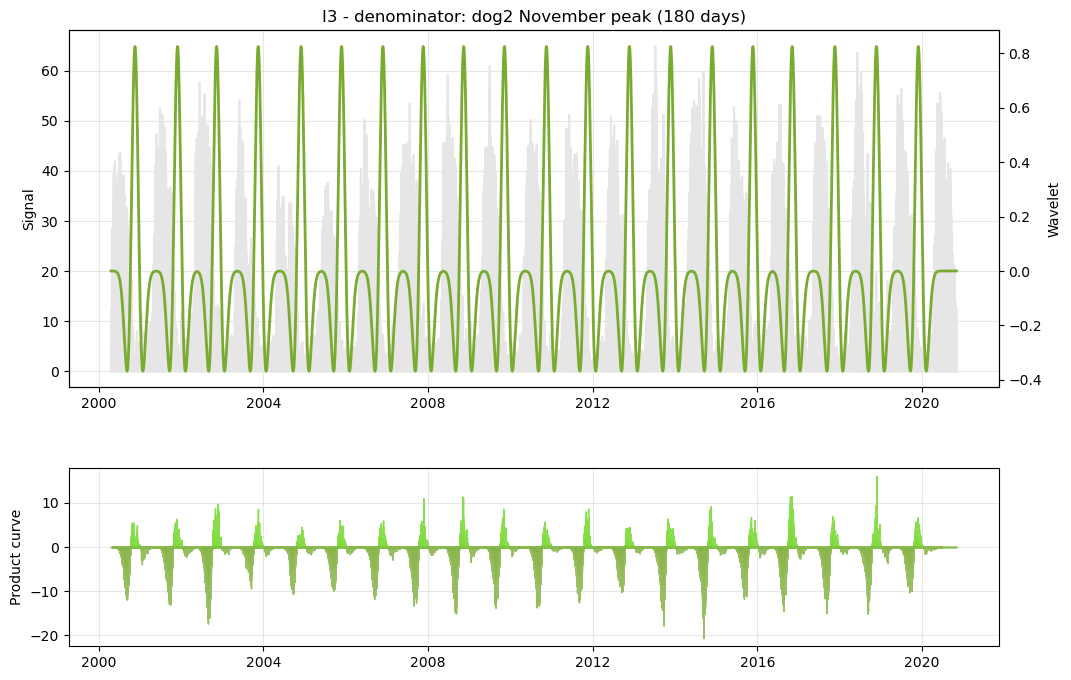

In [11]:
#%% Third Indicator : GPP drop importance
# Wavelet selection
wname = 'dog2'; 

# Indicator: ratio of June and November peaks (180 days)
I3 = wdata.peak[wname]['jun']['m6value']/wdata.peak[wname]['nov']['m6value'] # Ratio of June and November
I3.iloc[4] = np.nan # Set 2004 to NaN

# Parameters for WAI visualization
idx = np.arange(2000,2020+1,1)
per = 'm6' # Period to visualize
filter_dates = None # Dates to filter
filter_per = 'month' # Filter period
pmode = 'together' # Plotting mode

# Plotting - WAI for I3 (numerator)
perpeak = 'jun' # Peak to visualize (e.g. apr, jun, nov)
tit = 'I3 - numerator: dog2 June peak (180 days)'
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit)

# Plotting - WAI for I3 (denominator)
perpeak = 'nov' # Peak to visualize (e.g. apr, jun, nov)
tit = 'I3 - denominator: dog2 November peak (180 days)'
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit)


Zoom:

Using DataFrame index as xdata


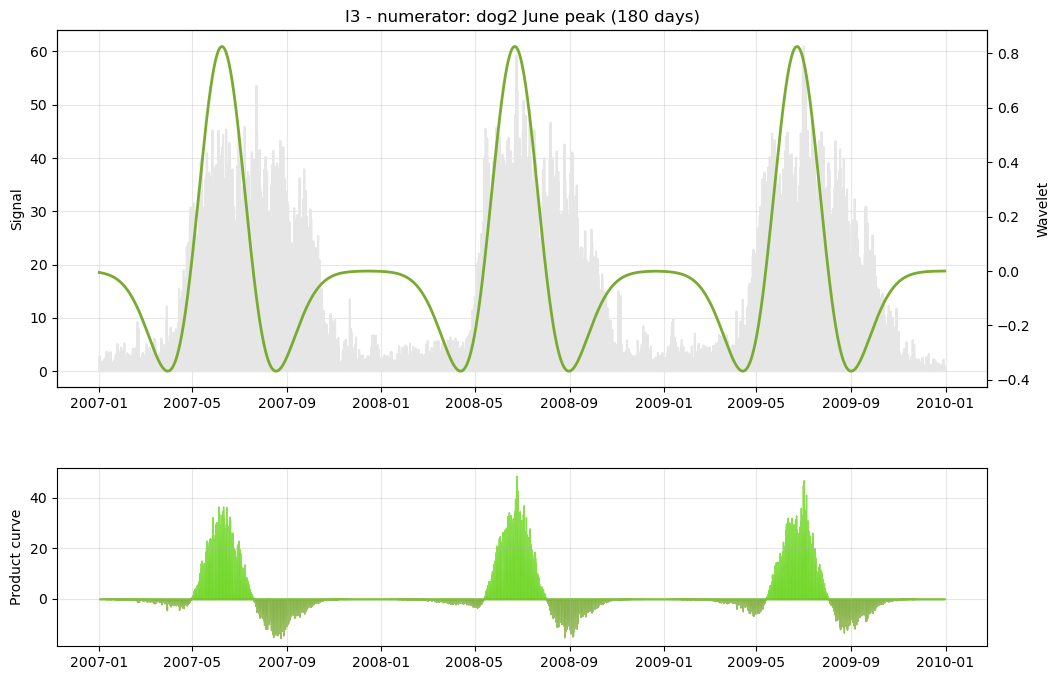

Using DataFrame index as xdata


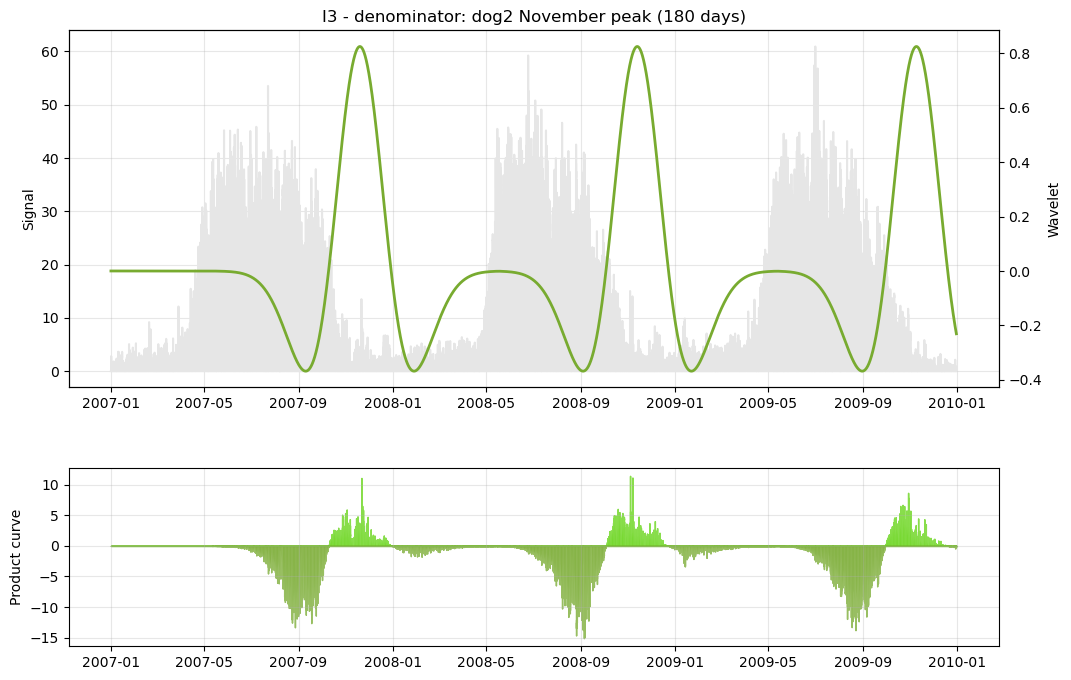

In [12]:
# Zoom on specific dates
xlims = [datetime(2007, 1, 1), datetime(2009, 12, 31)]

# WAI with zoom (numerator)
perpeak = 'jun' # Peak to visualize (e.g. apr, jun, nov)
tit = 'I3 - numerator: dog2 June peak (180 days)'
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit, xlims=xlims)

# WAI with zoom (denominator)
perpeak = 'nov' # Peak to visualize (e.g. apr, jun, nov)
tit = 'I3 - denominator: dog2 November peak (180 days)'
wdata.WAI(idx, per, data, wname=wname, perpeak=perpeak, 
          filter_dates=filter_dates, filter_per=filter_per, 
          plotting_mode=pmode, title=tit, xlims=xlims)

WAI can be used for applications other than defining indicators. Among these, automatic wavelet positioning can be exploited to detect x-axis positions relating to specific events.

For example, the dates of the start of the growing season, the mid-season drop and the end of the growing season are evaluated using peak positions.

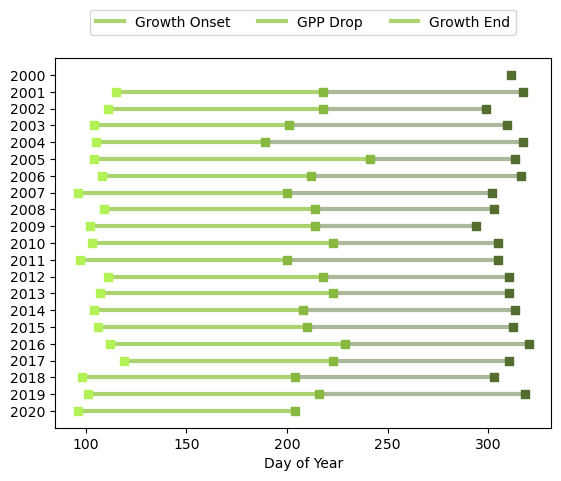

In [20]:
#%% Phenology data
# Wavelet selection
wname = 'dog2'; 

# Start growing seson: dog2 April peak at 2 months
BeginDate = wdata.peak[wname]["apr"]["m2loc"]

# Drop dates: Second zero of dog2 June peak
per = "m6"
DropDate = wdata.translate_peak(wdata.peak[wname]['jun'], per, wname) # Find minimum of wavelet
DropDate = DropDate.iloc[:, 0]  # Extracting the first column

# End dates: dog2 November peak at 2 months
EndDate = wdata.peak[wname]["nov"]["m2loc"]

# Creating array in Day-of-Year (DOY)
Pheno = pd.concat([BeginDate, DropDate, EndDate], axis=1)
# Ensure all columns in Pheno are datetime
Pheno = Pheno.apply(pd.to_datetime, errors='coerce')

# Apply the dayofyear attribute
Pheno = Pheno.apply(lambda x: x.dt.dayofyear)  # Convert dates to DOY

# Plotting - Dates
years = np.arange(2000, 2020 + 1)
plt.figure()
# plt.hold(True)  # Hold to overlay plots (for Matplotlib version < 3.0.0)

# Durations
plt.plot([Pheno.iloc[:, 0], Pheno.iloc[:, 1]], [years, years],
         color=[0.67, 0.83, 0.44], linewidth=3, label=None, zorder=1)
plt.plot([Pheno.iloc[:, 1], Pheno.iloc[:, 2]], [years, years],
         color=[0.67, 0.72, 0.60], linewidth=3, label=None, zorder=1)

# Events (scatter plot)
plt.scatter(Pheno.iloc[:, 0], years, marker="s", color=[0.70, 0.95, 0.34], label="Growth Onset", zorder=2)
plt.scatter(Pheno.iloc[:, 1], years, marker="s", color=[0.53, 0.72, 0.25], label="GPP Drop", zorder=2)
plt.scatter(Pheno.iloc[:, 2], years, marker="s", color=[0.33, 0.43, 0.19], label="Growth End", zorder=2)

# Axes and Legend
plt.gca().invert_yaxis()  # Reverse Y-axis
plt.yticks(years)
plt.xlabel("Day of Year")
plt.legend(["Growth Onset", "GPP Drop", "Growth End"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))
plt.show()